In [2]:
%pip install ipywidgets cartopy geopandas contextily matplotlib

  Using cached Cartopy-0.21.1.tar.gz (10.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
Using cached widgetsnbextension-4.0.14-py3-none-any.whl (2.2 MB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 25.8 MB/s eta 0:00:00a 0:00:01
Using cached geographiclib-2.0-py3-none-any.whl (40 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for cartopy (pyproject.toml) did not run successful

In [17]:
import ipywidgets as widgets
from IPython.display import display
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import geopandas as gpd
import contextily as ctx
import shap
import matplotlib.pyplot as plt

In [8]:
path = "/Users/I566184/bachelorarbeit_coding/mesogeos/csv/shap_map_csv"
file = "shap_map_mlp10-test-with-labels.csv"

In [18]:
def load_and_combine_csv_files(path):
    # Lade die CSV-Dateien
    mlp = pd.read_csv(f"{path}/shap_map_mlp.csv")
    cnn = pd.read_csv(f"{path}/shap_map_cnn.csv")
    transformer = pd.read_csv(f"{path}/shap_map_transformer.csv")
    gtn = pd.read_csv(f"{path}/shap_map_gtn.csv")
    gru = pd.read_csv(f"{path}/shap_map_gru.csv")
    lstm = pd.read_csv(f"{path}/shap_map_lstm.csv")

    # Kombiniere alle CSV-Dateien in ein gemeinsames DataFrame anhand der Spalten 'x' und 'y'
    combined_df = pd.merge(mlp, cnn, on=['x', 'y'], suffixes=('_mlp', '_cnn'))
    combined_df = pd.merge(combined_df, transformer, on=['x', 'y'], suffixes=('', '_transformer'))
    combined_df = pd.merge(combined_df, gtn, on=['x', 'y'], suffixes=('_transformer', '_gtn'))
    combined_df = pd.merge(combined_df, gru, on=['x', 'y'], suffixes=('_gtn', '_gru'))
    combined_df = pd.merge(combined_df, lstm, on=['x', 'y'], suffixes=('_gru', '_lstm'))

    return combined_df

In [50]:
import shap
import matplotlib.pyplot as plt

def plot_beeswarm_for_feature(combined_df, feature_name, models, model_names):
    """
    Plottet für ein bestimmtes Feature (z. B. 'lst_day') die SHAP-Wert-Verteilungen der Modelle untereinander.
    
    combined_df: DataFrame, das alle SHAP-Werte für alle Modelle enthält
    feature_name: Das Feature (z. B. 'lst_day'), für das die Plots erstellt werden sollen
    models: Liste der Modelle, z. B. ['mlp', 'cnn', 'transformer', 'gtn', 'gru', 'lstm']
    model_names: Liste der Modellnamen, z. B. ['MLP', 'CNN', 'Transformer', 'GTN', 'GRU', 'LSTM']
    """
    plt.figure(figsize=(12, len(models) * 4))  # Höhe anpassen, je nachdem, wie viele Modelle du hast

    # Setze eine einmalige Überschrift für das gesamte Plot
    plt.suptitle(f'SHAP values for {feature_name}', fontsize=16)

    for idx, model in enumerate(models):
        # Extrahiere die SHAP-Werte für das aktuelle Feature und Modell
        shap_values = combined_df[f'{feature_name}_{model}'].values

        # Reshaping der SHAP-Werte, um sicherzustellen, dass es eine 2D-Matrix für das Beeswarm-Diagramm gibt
        shap_values_for_feature = shap_values.reshape(-1, 1)

        # Erstelle den Beeswarm-Plot für das aktuelle Modell und Feature
        plt.subplot(len(models), 1, idx + 1)
        shap.summary_plot(shap_values_for_feature, show=False)

        # Beschrifte Y-Achse nur für den ersten Plot
        if idx == 0:
            plt.ylabel(f'Models: {", ".join(model_names)}')

        # Y-Achse mit Modellnamen beschriften (für jeden Plot)
        plt.yticks([0], [model_names[idx]])

        # Bildunterschrift nur einmal ganz unten hinzufügen
    plt.figtext(0.5, 0.01, f'Feature: {feature_name} - SHAP values distribution across models', ha='center', fontsize=12)

    # Stelle sicher, dass der Titel und die Bildunterschrift nicht überlappen
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Damit der Titel nicht überlappt
    plt.subplots_adjust(hspace=0.5)  # Vertikalen Abstand zwischen den Subplots vergrößern
    plt.show()

# Beispielaufruf:
models = ['mlp', 'cnn', 'transformer', 'gtn', 'gru', 'lstm']
model_names = ['MLP', 'CNN', 'Transformer', 'GTN', 'GRU', 'LSTM']

In [51]:
def plot_beeswarms_for_all_features(combined_df, features, models, model_names):
    for feature in features:
        plot_beeswarm_for_feature(combined_df, feature, models, model_names)

# Liste der Features, für die du die SHAP-Werte visualisieren möchtest
features = ['d2m', 'lst_day', 'ndvi', 'rh', 't2m', 'wind_speed', 'lai', 'lst_night', 'ssrd', 'tp']

/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes d

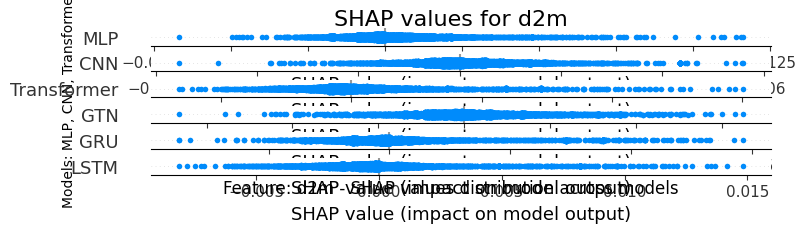

/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes d

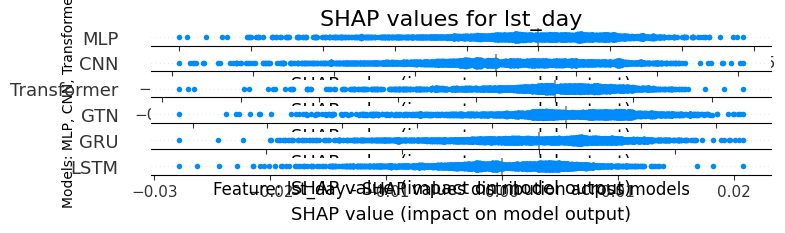

/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes d

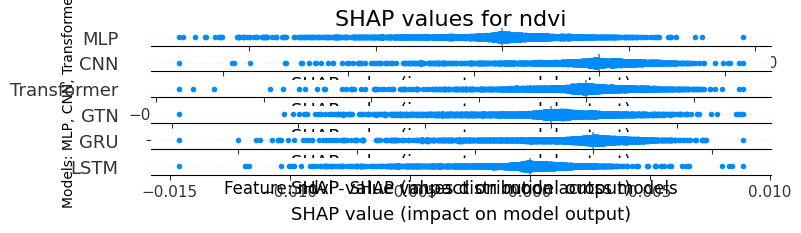

/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes d

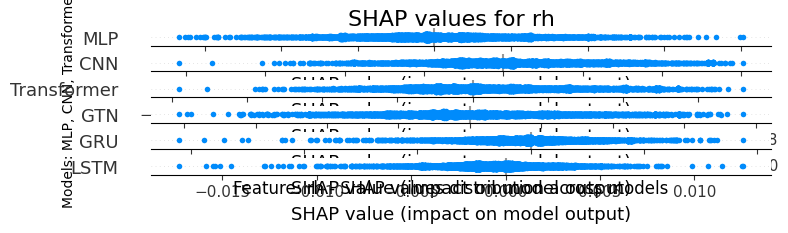

/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes d

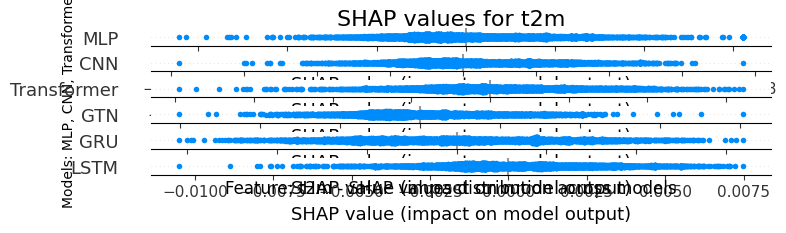

/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes d

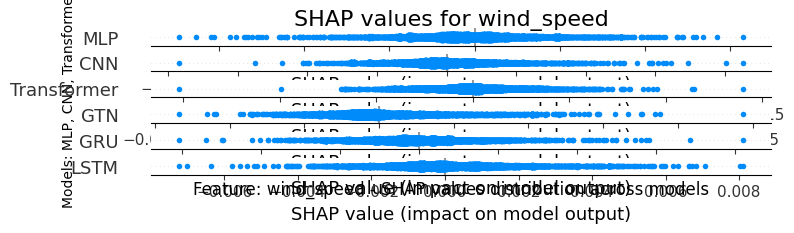

/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes d

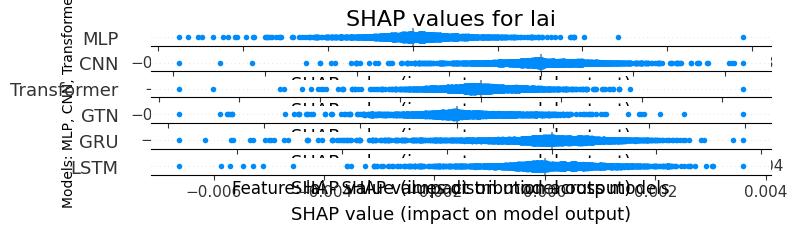

/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes d

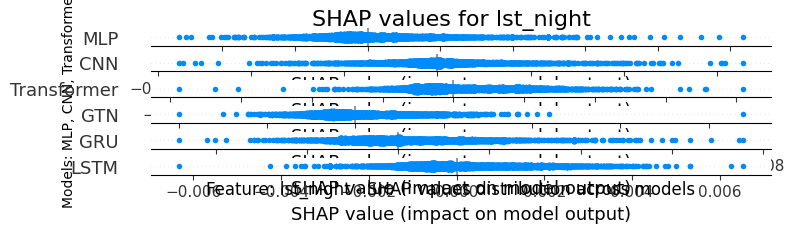

/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes d

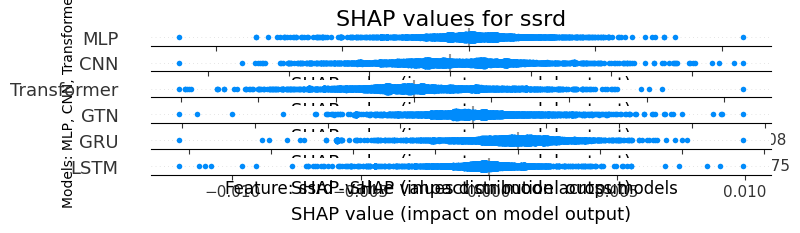

/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pl.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/ddfirepred/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes d

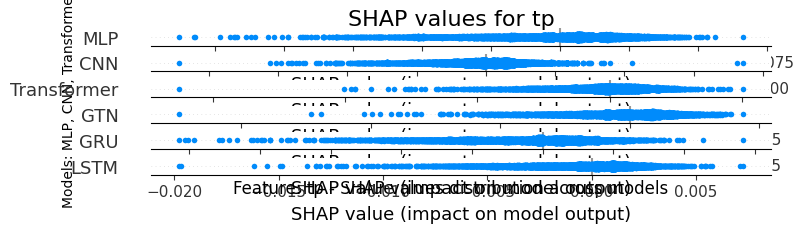

In [52]:
combined_df = load_and_combine_csv_files(path)
plot_beeswarms_for_all_features(combined_df, features, models, model_names)


In [5]:
df = pd.read_csv(f"{path}/{file}")
df.rename(columns={"x": "lon", "y": "lat"}, inplace=True)
df_pos = df[df["label"] == 1] #rename to df to only show positive labels
df_neg = df[df["label"] == 0] #rename to df to only show negative labels

feature_names = [col for col in df.columns if col not in ["lon", "lat"]]
dropdown = widgets.Dropdown(
    options=feature_names,
    value=feature_names[0],
    description='SHAP Feature:'
)

def plot_feature_map(feature_name):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set extent basierend auf Longitude (x) und Latitude (y)
    ax.set_extent([
        df["lon"].min() - 1, df["lon"].max() + 1,
        df["lat"].min() - 1, df["lat"].max() + 1
    ], crs=ccrs.PlateCarree())

    # Basemap
    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#f0e9dc')
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#cce6ff')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='lightblue', edgecolor='k', linewidth=0.3)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.2)

    # Scatterplot
    sc = ax.scatter(df["lon"], df["lat"], c=df[feature_name], cmap='viridis',
                    s=5, alpha=0.8, transform=ccrs.PlateCarree())

    # Colorbar
    cb = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label(f'SHAP: {feature_name}')

    plt.title(f"SHAP Values for '{feature_name}' - MLP")
    plt.show()
widgets.interact(plot_feature_map, feature_name=dropdown);


interactive(children=(Dropdown(description='SHAP Feature:', options=('d2m', 'dem', 'lai', 'lc_agriculture', 'l…

In [36]:
def plot_shap_geopandas(df, shap_column, title="SHAP Map", cmap="viridis"):
    """
    df: Pandas DataFrame mit Spalten 'lat', 'lon' und dem SHAP-Feature
    shap_column: Name der Spalte mit SHAP-Werten (z. B. 'wind_speed')
    """
    # Erstelle GeoDataFrame mit Punkten aus lat/lon
    gdf = gpd.GeoDataFrame(df,
                           geometry=gpd.points_from_xy(df['lon'], df['lat']),
                           crs="EPSG:4326")  # WGS84
    # Reprojiziere in Web-Mercator (für Hintergrundkarten wie OpenStreetMap)
    gdf = gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, column=shap_column, cmap=cmap, legend=True, markersize=10, alpha=0.8)

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter)

    ax.set_axis_off()
    ax.set_title(f"SHAP Values for {shap_column}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
df = pd.read_csv(f"{path}/{file}")
df.rename(columns={"x": "lon", "y": "lat"}, inplace=True)
plot_shap_geopandas(df, shap_column="wind_speed", title="SHAP für wind_speed")